In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

In [2]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> Tuple[np.ndarray, np.ndarray]:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return (its_obj.lagtimes, its_obj.timescales)

def its_2(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> Tuple[np.ndarray, np.ndarray]: 
    all_ts = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        cmat = m.count_matrix_active
        tmat = _transition_matrix(cmat, reversible=True)
        ts = _timescales(tmat, tau=lag)[1:nits+1]
        all_ts.append(ts.reshape(1, -1))
    ts = np.concatenate(all_ts)
    return (lags, ts)
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix]





In [3]:
def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary

In [4]:
hp_ix = 0
protein = '1fme'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits=25

hps = pd.read_hdf('../data/msms/hpsample.h5')
top_path = f'/home/rob/Data/DESRES/DESRES-Trajectory_{protein.upper()}-0-protein/{protein.upper()}-0-protein/protein.pdb'
traj_paths = list(Path('/home/rob/Data/DESRES/').rglob(f'*{protein.upper()}*/**/*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths

compare_ts = pd.read_hdf(f'../data/msms/{protein}/summary.h5', key='timescales')
compare_ts_samples = pd.read_hdf(f'../data/msms/{protein}/raw_ts.h5', key='ts')
bs_dict = pickle.load(open(f"../data/msms/{protein}/bs_dict.pkl", 'rb'))

In [5]:
ftrajs_all = featurizer(hps.iloc[hp_ix, :].to_dict(), traj_paths, top_path)

In [6]:
samples = []
for i in range(n_bootstraps):
    print(i, end=', ')
    ix = bs_dict[i]
    ftrajs = [ftrajs_all[j] for j in ix]
    
    assert len(ftrajs) == len(ftrajs_all)
    ttrajs, tica_mod = tica(hps.iloc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.iloc[hp_ix, :].to_dict(), ttrajs, seed)
    ts = its(dtrajs, lags, nits=nits)
    samples.append(ts[1][..., np.newaxis])
samples = np.concatenate(samples, axis=-1)

0, 

In [7]:
ts[1][:, 0]

array([ 290.86239513,  727.66124282, 1050.68473744, 1305.14847878,
       1509.18112774, 1677.1621909 , 1820.82138484, 1955.48921023,
       2064.03264165, 2166.64027003, 2252.07053554])

array([ 290.86239513,  727.66124282, 1050.68473744, 1305.14847878,
       1509.18112774, 1677.1621909 , 1820.82138484, 1955.48921023,
       2064.03264165, 2166.64027003, 2252.07053554])

In [31]:
target_ts_samples = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
target_ts_samples.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
target_ts = summarise(target_ts_samples)

In [32]:
comparison = pd.merge(target_ts, compare_ts, left_index=True, right_index=True, how='left')

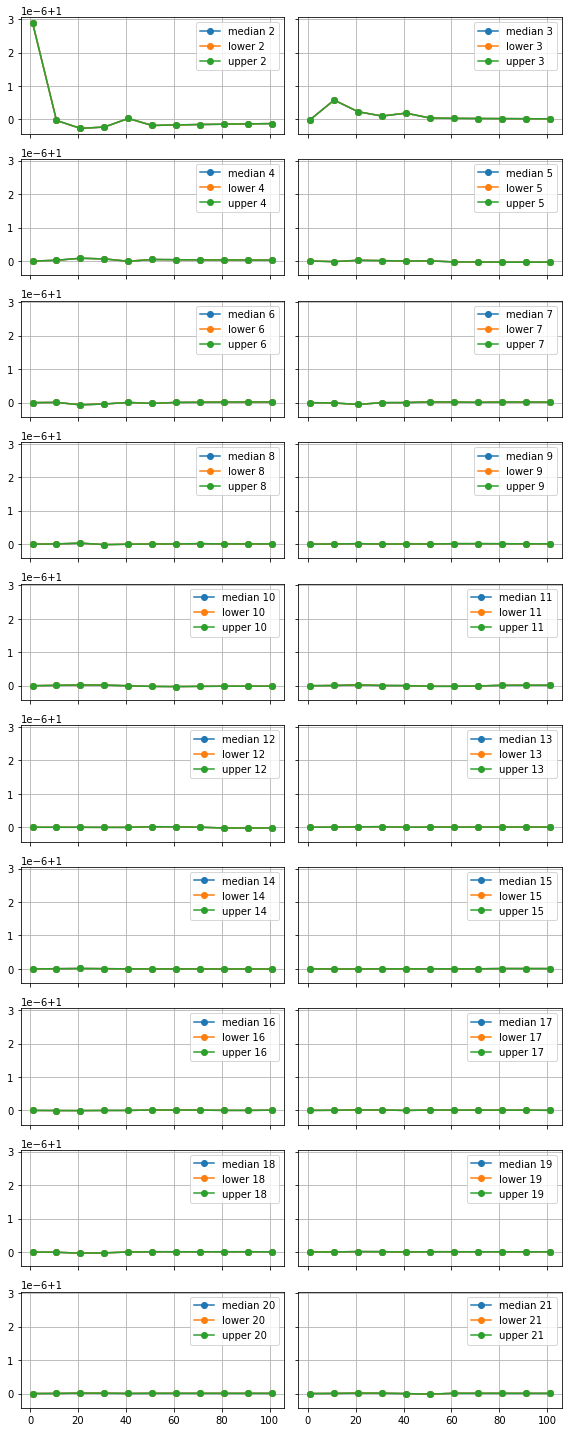

In [33]:
fig, axes = plt.subplots(10, 2, figsize=(8, 20), sharex=True, sharey=True)
num_plots = axes.flatten().shape[0]
for k, v in comparison.groupby(['hp_ix', 'process']):
    if k[1]-2 < num_plots:
        lags = v.index.get_level_values(level=1)
        ax = axes.flatten()[k[1]-2]
        ax.plot(lags, v['median_y']/v['median_x'], label=f'median {k[1]}', marker='o')
        ax.plot(lags, v['lb_y']/v['lb_x'], label=f'lower {k[1]}', marker='o')
        ax.plot(lags, v['ub_y']/v['ub_x'], label=f'upper {k[1]}', marker='o')
        # ax.plot(lags, v['count_y']-v['count_x'], label=f'count {k[1]}', marker='o')

        # ax.set_yscale('log')
        # ax.set_ylim(0.99, 1.01)
        ax.grid()
        ax.legend()
        
plt.tight_layout()
